# 08 — Introduction to Markov Chains
*A visual, hands‑on primer with NumPy + Matplotlib*

**What you'll learn**
- Markov property, transition matrices, and multi‑step transitions
- Simulating Markov chains & visualizing convergence
- Stationary distributions, ergodicity, mixing
- Absorbing chains & absorption probabilities
- Markov **Reward** Processes (MRPs) and Bellman equations (link to RL)
- Mini PageRank demo

> **How to use:** Read each *Theory* block, then run the following code cells.

## 1. Markov Chains — Core Ideas

A **discrete-time Markov chain (DTMC)** is a sequence of random variables $X_0, X_1, \ldots$ on a finite state space $\mathcal{S} = \{1,\dots,n\}$ satisfying the **Markov property**:

$$
\Pr[X_{t+1}=j|X_t=i, X_{t-1},\dots] 
\;=\; 
\Pr[X_{t+1}=j|X_t=i]
\;=\;
P_{ij}.
$$

The matrix $P \in \mathbb{R}^{n \times n}$ is the **transition matrix**, where:

- $P_{ij} \ge 0$
- $\sum_j P_{ij} = 1$ (each row is a probability distribution)
- A **state distribution** is a row vector $\mu \in \Delta^{n-1}$.
- One-step evolution:  
  $$
  \mu_{t+1} = \mu_t P .
  $$

**k-step transitions (Chapman–Kolmogorov):**

$$
\Pr[X_{t+k}=j|X_t=i] = (P^k)_{ij},
\qquad
\mu_{t+k} = \mu_t P^k.
$$

This shows how a Markov chain evolves over time via matrix powers.


### Why this matters for RL

In reinforcement learning, an **MDP** augments Markov chains with *actions*. For each action $a$, there is a transition matrix $P^a$. A fixed policy $\pi(a|s)$ induces a **Markov chain over states** with:

$$
P^\pi = \sum_{a} \Pi_a \, P^a,
$$

where $\Pi_a = \mathrm{diag}(\pi(a|s_1), \ldots, \pi(a|s_n))$.

Thus, many RL concepts — stationary distributions, mixing, long-term visitation frequencies, discounted returns — rest directly on Markov chain behavior.

Markov chains are the foundation for understanding value functions, policy evaluation, and the dynamics of exploration in MDPs.

Row sums (should be 1.0): [1. 1. 1. 1.]

Distribution after 1 step (pi1): [0.1  0.85 0.05 0.  ]
Distribution after 5 steps (pi5): [0.292 0.467 0.133 0.107]
Distribution after 10 steps (pi10): [0.198 0.315 0.294 0.193]
Distribution after 15 steps (pi15): [0.214 0.252 0.27  0.264]
Distribution after 20 steps (pi20): [0.24  0.246 0.245 0.269]


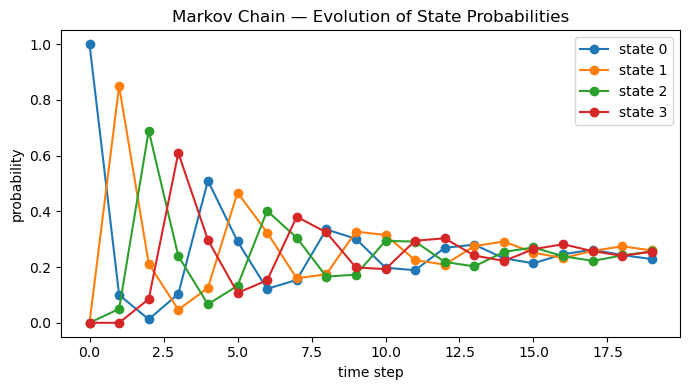

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Cleaner printing for matrices
np.set_printoptions(precision=3, suppress=True)

# Transition matrix for a simple 4-state Markov chain
P = np.array([
    [0.10, 0.85, 0.05, 0.00], # from state 0
    [0.00, 0.15, 0.80, 0.05], # from state 1
    [0.05, 0.00, 0.10, 0.85], # from state 2
    [0.80, 0.05, 0.00, 0.15], # from state 3
], dtype=float)

# Verify stochasticity (each row should sum to 1)
print("Row sums (should be 1.0):", P.sum(axis=1))

# One-step and multi-step evolution
pi0 = np.array([1.0, 0.0, 0.0, 0.0]) # Start in state 0 with full probability

pi1 = pi0 @ P # distribution after 1 step
pi5 = pi0 @ np.linalg.matrix_power(P, 5) # distribution after 5 steps
pi10 = pi0 @ np.linalg.matrix_power(P, 10) # distribution after 10 steps
pi15 = pi0 @ np.linalg.matrix_power(P, 15) # distribution after 15 steps
pi20 = pi0 @ np.linalg.matrix_power(P, 20) # distribution after 20 steps

print("\nDistribution after 1 step (pi1):", pi1)
print("Distribution after 5 steps (pi5):", pi5)
print("Distribution after 10 steps (pi10):", pi10)
print("Distribution after 15 steps (pi15):", pi15)
print("Distribution after 20 steps (pi20):", pi20)

# Visualize how distributions evolve over time
T = 20
dist = np.zeros((T, 4))
dist[0] = pi0

for t in range(1, T):
    dist[t] = dist[t-1] @ P

plt.figure(figsize=(7,4))
for s in range(4):
    plt.plot(dist[:, s], marker='o', label=f"state {s}")

plt.title("Markov Chain — Evolution of State Probabilities")
plt.xlabel("time step")
plt.ylabel("probability")
plt.legend()
plt.tight_layout()
plt.show()

## 2. Stationary Distribution & Ergodicity

A distribution $\pi^*$ is **stationary** for a Markov chain with transition matrix $P$ if:
$$
\pi^* = \pi^* P, 
\qquad \sum_{i} \pi^*_i = 1, 
\qquad \pi^*_i \ge 0.
$$
It is a **fixed point** of the dynamics — once the chain reaches $\pi^*$, it stays there forever.

### Ergodicity
A finite Markov chain is **ergodic** if it is:
- **Irreducible** (all states communicate), and  
- **Aperiodic** (no deterministic cycles).

For an ergodic chain:
$$
\lim_{t \to \infty} \pi_0 P^t = \pi^*, 
$$
meaning **all initial distributions converge** to the same stationary distribution. This is the long-run behavior of the system.

### Computing $\pi^*$
Several equivalent methods:
- As the **left eigenvector** of $P$ for eigenvalue 1:  
  $$
  \pi^* P = \pi^*.
  $$
- Solve the linear system:  
  $$
  (I - P^\top)\pi = 0, \qquad \sum_i \pi_i = 1.
  $$
- Empirically by **power iteration**: repeatedly apply $P$ to any distribution vector.

### RL Connection
In Reinforcement Learning, a **policy $\pi(a|s)$** induces a Markov chain over states with transition matrix:
$$
P^{\pi}(s'|s) = \sum_a \pi(a|s)\, P(s'|s, a).
$$
Its stationary distribution $d^{\pi}$ describes **how often the agent visits each state** in the long run.  
This distribution directly affects:
- **State visitation frequencies** (important for exploration),
- **Policy gradient estimates** (reward expectations weighted by $d^{\pi}$),
- **Value function definitions** in continuing tasks.

> In short: *stationary distributions tell us what the agent “sees” most often under a fixed policy.*

Eigenvalue closest to 1: (1.000000000000002+0j)
Stationary distribution π*: [0.242 0.258 0.242 0.258]
Empirical (T = 2000): [0.242 0.258 0.242 0.258]
L1 difference ||π* - empirical||₁: 2.942091015256665e-15


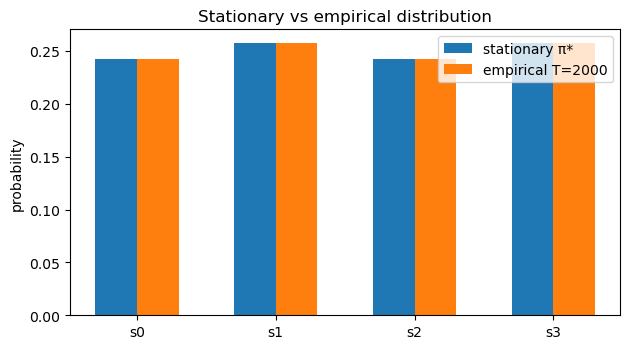

In [7]:
# Evolve distribution over time (needed for empirical distribution)
T = 2000
pi = pi0.copy() # from earlier: pi0 = [1,0,0,0]
emp = [pi.copy()]

for _ in range(T):
    pi = pi @ P # evolve one step
    emp.append(pi.copy())

emp = np.array(emp)

# Stationary distribution via left eigenvector of P
evals, evecs = np.linalg.eig(P.T)
idx = np.argmin(np.abs(evals - 1.0))
v = np.real_if_close(evecs[:, idx])
pi_star = v / v.sum()
pi_star = np.maximum(pi_star, 0); pi_star = pi_star / pi_star.sum()

print("Eigenvalue closest to 1:", evals[idx])
print("Stationary distribution π*:", np.round(pi_star, 6))

# Compare with empirical long-run distribution
emp_last = emp[-1]
print("Empirical (T = {}):".format(len(emp)-1), np.round(emp_last, 6))

print("L1 difference ||π* - empirical||₁:",
      float(np.sum(np.abs(pi_star - emp_last))))

# Plot
labels = [f"s{i}" for i in range(P.shape[0])]
x = np.arange(len(labels))

plt.figure(figsize=(6.4,3.6))
plt.bar(x-0.15, pi_star, width=0.3, label="stationary π*")
plt.bar(x+0.15, emp_last, width=0.3, label=f"empirical T={len(emp)-1}")
plt.xticks(x, labels)
plt.ylabel("probability"); plt.title("Stationary vs empirical distribution")
plt.legend(); plt.tight_layout(); plt.show()

## 3. Absorbing Chains & Absorption Probabilities

A **Markov chain** is *absorbing* if it contains at least one **absorbing state** (i.e., a state $ i $ such that $P_{ii} = 1$) and from any other state there is a path to some absorbing state.

We reorder the states into:
- **Transient states** $T$
- **Absorbing states** $A$

so that the transition matrix becomes block-structured:
$$
P = 
\begin{pmatrix}
Q & R \\
0 & I
\end{pmatrix},
$$
where:

- $ Q \in \mathbb{R}^{|T| \times |T|} $ describes transitions *among transient* states  
- $ R \in \mathbb{R}^{|T| \times |A|} $ describes transitions *from transient → absorbing*  
- $ I $ is an identity matrix for absorbing states (they remain where they are)

### Fundamental Matrix

The **fundamental matrix** is:
$$
N = (I - Q)^{-1},
$$
and it encodes the expected number of times the chain visits each transient state before absorption.

### Absorption Probabilities

The probability of being absorbed in each absorbing state, starting from each transient state, is:
$$
B = N R,
$$
where $B_{ij}$ is the probability of eventual absorption in absorbing state $j$ given that we start in transient state $i$.

### RL Connection

Absorbing chains relate directly to **episodic RL**:

- Termination states in an MDP correspond to **absorbing states**
- The matrix $Q$ describes transient transitions before the episode ends
- Absorption probabilities mirror **termination likelihoods**, relevant for:
  - episodic value calculations,
  - analyzing horizon lengths,
  - proving convergence of TD methods on finite MDPs.

Absorbing MDPs are also the basis of **absorbing Markov decision processes**, useful in safety-constrained RL and risk analysis.

In [12]:
# Toy absorbing chain: states 0,1 transient; states 2,3 absorbing
P_abs = np.array([
    [0.5, 0.4, 0.1, 0.0],  # state 0 (transient)
    [0.2, 0.5, 0.0, 0.3],  # state 1 (transient)
    [0.0, 0.0, 1.0, 0.0],  # state 2 (absorbing)
    [0.0, 0.0, 0.0, 1.0],  # state 3 (absorbing)
], dtype=float)

# Partition into Q (transient→transient) and R (transient→absorbing)

Q = P_abs[:2, :2] # states 0,1 → 0,1
R = P_abs[:2, 2:] # states 0,1 → 2,3

I = np.eye(Q.shape[0])

# Fundamental matrix: expected #visits to transient states before absorption
N = np.linalg.inv(I - Q)

# Absorption probabilities: B[i,j] = P(absorbed in j | start in i)
B = N @ R

np.set_printoptions(precision=4, suppress=True)

print("Q (transient→transient):\n", Q)
print("\nR (transient→absorbing):\n", R)
print("\nFundamental matrix N = (I - Q)^(-1):\n", N)
print("\nAbsorption probabilities B = N R:\n", B)

# Each row of B should sum to 1 (eventually absorbed somewhere)
print("\nRow sums of B (should be ~1):", B.sum(axis=1))

Q (transient→transient):
 [[0.5 0.4]
 [0.2 0.5]]

R (transient→absorbing):
 [[0.1 0. ]
 [0.  0.3]]

Fundamental matrix N = (I - Q)^(-1):
 [[2.9412 2.3529]
 [1.1765 2.9412]]

Absorption probabilities B = N R:
 [[0.2941 0.7059]
 [0.1176 0.8824]]

Row sums of B (should be ~1): [1. 1.]


## 4. Markov **Reward** Processes (MRPs) & the Bellman Equation

A **Markov Reward Process (MRP)** adds *rewards* and *discounting* to a Markov chain. Formally, an MRP is a tuple $(\mathcal{S}, P, r, \gamma)$:

- $P$: transition matrix  
- $r(s)$: expected immediate reward in state $s$  
- $\gamma \in [0,1)$: discount factor  
- Value function:
  $$
  v(s) = \mathbb{E}\left[\sum_{t=0}^\infty \gamma^t R_{t}|S_0=s\right]
  $$

The **Bellman equation** for MRPs is:
$$
v = r + \gamma P v
$$
This gives a closed-form solution:
$$
v = (I - \gamma P)^{-1} r.
$$

### Why this matters for RL
- In an **MDP**, picking a policy $\pi(a|s)$ induces an MRP with transition matrix:
  $$
  P^\pi = \sum_{a} \pi(a|s) P^{a}
  $$
- Policy evaluation reduces to solving:
  $$
  v^\pi = r^\pi + \gamma P^\pi v^\pi
  $$
- All value-based RL algorithms (TD, Monte Carlo, Dynamic Programming, DQN) are approximations to this equation.
- Understanding MRPs builds intuition for stability, contraction mappings, and why iterative Bellman updates converge.

This section bridges Markov chains → MRPs → full RL.

In [13]:
# Markov Reward Process (MRP) Evaluation

# Discount and per-state rewards
gamma = 0.95
r = np.array([+1.0, -0.2, +0.3, 0.0], dtype=float)   # reward for each state

# Identity
I = np.eye(P.shape[0])

# Closed-form Bellman solution: v = (I - γP)^(-1) r
A = I - gamma * P
v_closed = np.linalg.solve(A, r)

print("Closed-form value v:", np.round(v_closed, 4))

# Iterative (Dynamic Programming) Policy Evaluation
# v_{k+1} = r + γ P v_k
v_it = np.zeros_like(r)
num_iter = 300

for _ in range(num_iter):
    v_it = r + gamma * (P @ v_it)

print("Iterative value v:", np.round(v_it, 4))

# L∞ difference between iterative and closed-form
err = np.max(np.abs(v_closed - v_it))
print("Max difference:", round(err, 6))

Closed-form value v: [5.6715 4.8031 5.3517 5.2927]
Iterative value v: [5.6715 4.8031 5.3517 5.2927]
Max difference: 1e-06


## 5. Mini PageRank (Random Surfer Model)

PageRank models a **random surfer** on a directed graph.  
If a webpage has outgoing links, the surfer follows one at random; otherwise, they **teleport** uniformly.

Given a link matrix $S$ (row-stochastic) and damping factor $\alpha \in (0,1)$, the **Google transition matrix** is:

$$
P_{\alpha} \;=\; \alpha S \;+\; (1-\alpha)\frac{1}{n}\mathbf{1}\mathbf{1}^\top,
$$

where:
- $ \alpha \approx 0.85 $ is the probability of following a real link.
- $ (1-\alpha) $ is the probability of teleportation to any page.
- $n$ is the number of nodes.

The **PageRank vector** $ \pi^* $ is the stationary distribution:

$$
\pi^* = \pi^* P_{\alpha}, 
\quad \sum_i \pi^*_i = 1.
$$

Because $P_\alpha$ is **irreducible** and **aperiodic**, it has a **unique** stationary distribution, and power iteration converges rapidly.

### RL Connection
PageRank is mathematically identical to evaluating the **value distribution** of a random policy in an MDP with:
- teleportation → exploration bonus,
- link structure → transition probabilities.

This mirrors **entropy-regularized RL** and **stochastic policies** where transitions combine structured dynamics with exploration.

Link matrix S:
[[0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.5 0.  0.  0.5]
 [1.  0.  0.  0. ]]
Row sums S: [1. 1. 1. 1.]

Google matrix P_pr:
[[0.0375 0.4625 0.4625 0.0375]
 [0.0375 0.0375 0.4625 0.4625]
 [0.4625 0.0375 0.0375 0.4625]
 [0.8875 0.0375 0.0375 0.0375]]
Row sums P_pr: [1. 1. 1. 1.]

Eigenvalue closest to 1: (1.0000000000000009+0j)
PageRank π*: [0.3374 0.1809 0.2578 0.2239]  sum: 1.0


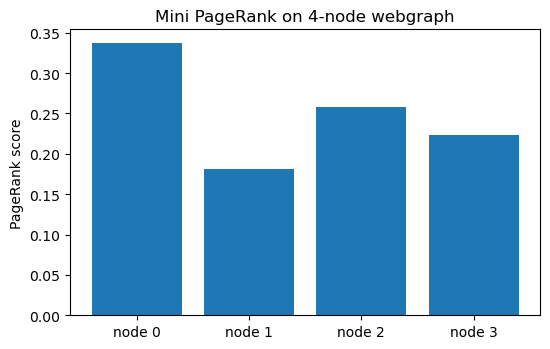

In [15]:
np.set_printoptions(precision=4, suppress=True)

A = np.array([
    [0, 1, 1, 0],  # 0 -> 1,2
    [0, 0, 1, 1],  # 1 -> 2,3
    [1, 0, 0, 1],  # 2 -> 0,3
    [1, 0, 0, 0],  # 3 -> 0
], dtype=float)

n = A.shape[0]

# Build S: row-stochastic link matrix
S = A.copy()
row_sums = S.sum(axis=1, keepdims=True)

for i in range(n):
    if row_sums[i, 0] > 0: # non-dangling row → normalize
        S[i, :] /= row_sums[i, 0]
    else: # dangling row → uniform
        S[i, :] = 1.0 / n

print("Link matrix S:")
print(S)
print("Row sums S:", S.sum(axis=1))

# Google matrix P_pr
alpha = 0.85
teleport = np.ones((n, n)) / n
P_pr = alpha * S + (1 - alpha) * teleport

print("\nGoogle matrix P_pr:")
print(P_pr)
print("Row sums P_pr:", P_pr.sum(axis=1))

# PageRank as stationary distribution of P_pr
evals, evecs = np.linalg.eig(P_pr.T)
idx = np.argmin(np.abs(evals - 1.0))
v = np.real_if_close(evecs[:, idx])
pr = v / v.sum()
pr = np.maximum(pr, 0.0)
pr = pr / pr.sum()

print("\nEigenvalue closest to 1:", evals[idx])
print("PageRank π*:", np.round(pr, 4), " sum:", pr.sum())

# Plot
labels = [f"node {i}" for i in range(n)]
x = np.arange(n)

plt.figure(figsize=(5.6, 3.6))
plt.bar(x, pr)
plt.xticks(x, labels)
plt.ylabel("PageRank score")
plt.title("Mini PageRank on 4-node webgraph")
plt.tight_layout()
plt.show()


## Key Takeaways

- **Markov chain dynamics:** Distributions evolve by multiplication with the transition matrix $\pi_{t+1} = \pi_t P$, and multi-step transitions follow $P^k$.  
- **Stationary distributions:** For an ergodic chain, all initial distributions converge to the unique long-run distribution $\pi^*$.  
- **Absorbing chains:** Transient–absorbing structure leads to closed-form absorption probabilities via the fundamental matrix $N=(I-Q)^{-1}$.  
- **Markov Reward Processes (MRPs):** Adding rewards and discount yields value functions solving the Bellman equation $v = r + \gamma P v$.  
- **Policies induce chains:** In an MDP, fixing a policy $\pi(a|s)$ produces a Markov chain with transition matrix $P^\pi$, laying the foundation for prediction and control in RL.


**Next:** Although the logical next step is `Phase 1 — Fundamentals` (MDPs, Bellman equations, Dynamic Programming, Monte Carlo, TD learning), it’s highly recommended to solidify Phase 0 foundations first through hands-on mini-projects.  
Start with `09_linear_regression_project.ipynb` to reinforce key ML and numerical concepts before diving into full RL.